<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dataset download from temporary 0x0.st

In [1]:
!curl http://0x0.st/HpsS.zip > dataset.zip
!ls dataset && rm -r dataset
!unzip dataset.zip -d dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3M  100 11.3M    0     0  20.5M      0 --:--:-- --:--:-- --:--:-- 20.5M
ls: cannot access 'dataset': No such file or directory
Archive:  dataset.zip
   creating: dataset/valid/
  inflating: dataset/valid/20180910_153936_5b97bea9ddf2b358f90f884b_jpg.rf.bd21c8dd22ab72203e447876f98b8031.jpg  
  inflating: dataset/valid/EKF-UKF_jpg.rf.8806f6a948a6c61b96ed9d830d813753.jpg  
  inflating: dataset/valid/FqyewkjWwAE9ZsK_jpg.rf.dd1a8ab6b2d03fc455b512e8a6be8caf.jpg  
  inflating: dataset/valid/_annotations.coco.json  
  inflating: dataset/valid/D1D9CE52-103C-4BA1-A550-4F6F1018DC66_1_105_c-1_jpeg.rf.3ec235a322a99136a587c56039daa1db.jpg  
   creating: dataset/test/
  inflating: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68.jpg  
  inflating: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872.jpg  
  inflating:

## Dependencies

In [1]:
!python3 -m pip install --upgrade pip
!python3 -m pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
			  torch \
              torchvision \
			  pycocotools \
			  pandas \
			  seaborn \
              torchviz -Uq && echo "Dependencies installation complete."

Dependencies installation complete.


## WandB login

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [2]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 8

In [3]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

In [4]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from typing import Tuple, List
from PIL import Image
from collections import defaultdict as DD

import torchvision.transforms as transforms
import torchvision.transforms.functional as fun
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import cv2

import os

class CocoSegmentationDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 annotation_file: str,
                 do_transform: bool = True,
                 common_size: Tuple[int, int] = (512, 512),
                ):
        self.root_dir = root_dir
        self.common_size = common_size
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.category_ids = self.coco.getCatIds()
        self.num_categories = len(self.category_ids)

        if do_transform:
            self.transform = transforms.Compose([
                transforms.Resize(self.common_size),
                transforms.ToTensor(),
            ])

        self.normalize = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.coco.getImgIds())

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        annotations = self.coco.loadAnns(ann_ids)

        image = Image.open(image_path).convert("RGB")

        masks = np.zeros((self.num_categories, *self.common_size), dtype=np.float32)
        for ann in annotations:
            masks_buf = np.zeros((self.num_categories, *self.common_size), dtype=np.float32)
            cat_id = ann["category_id"]
            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.common_size, interpolation=cv2.INTER_NEAREST)
            masks_buf[cat_id - 1, :, :] = mask

            masks = np.maximum(masks_buf, masks)

        masks = torch.from_numpy(masks)

        if self.transform:
            image = self.transform(image)

        return image / 255, masks

dataset = CocoSegmentationDataset(root_dir="dataset/train/",
                                  annotation_file="dataset/train/_annotations.coco.json")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


torch.Size([3, 512, 512]) torch.Size([3, 512, 512])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


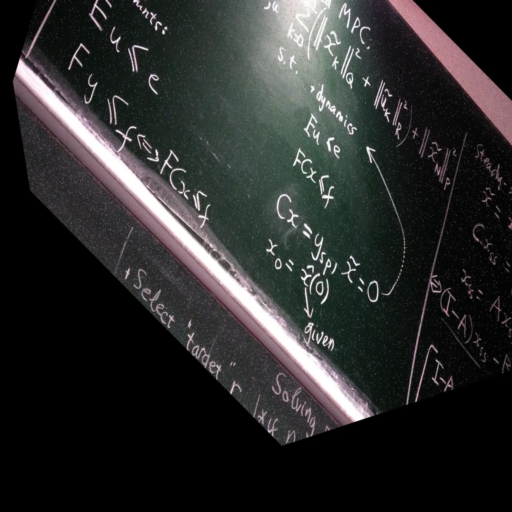

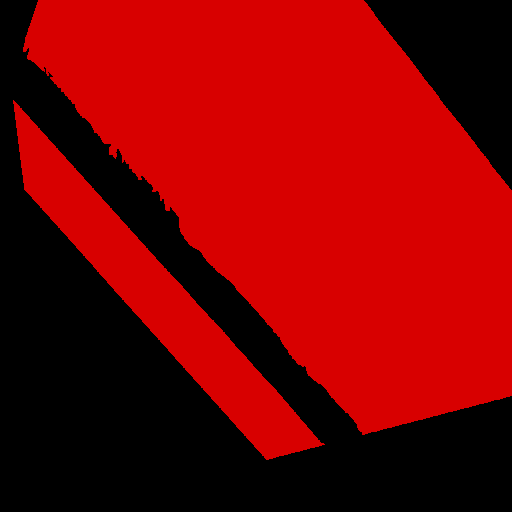

In [5]:
for batch in dataloader:
    imgs, masks = batch
    print(f"{imgs[0].shape} {masks[0].shape}")
    print(imgs[0])
    display(tensor_to_pil(imgs[0] * 255))
    display(tensor_to_pil(masks[0] * 40))
    break

## FeynMAN Model Definition

In [6]:
import torch
import torch.nn as nn

from torch import Tensor

class FeynMAN(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 3):
        super(__class__, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Training

In [7]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

Mon Sep  4 15:15:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 36%   38C    P2    19W / 120W |      1MiB /  6076MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataloader: DataLoader,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="feynman_2",

        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "architecture": "FeynMAN",
        "dataset": "feynman_v7i",
        }
    )

    # Watch the model for cool weights & biases
    wandb.watch(model)

    # criterion = nn.CrossEntropyLoss() # nn.BCELoss() #### TODO: change?
    criterion = nn.BCELoss()
    params = model.parameters()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # dataset = PNGMaskDataset(dataset_dir)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("BEGIN TRAINING!")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(epoch)

        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device) #.float()
            print("#", batch_idx)

            # Forward pass
            outputs = model(images)
            print("post forward pass")
            loss = criterion(outputs, masks)
            print("loss done")

            # Backpropagation and optimization
            optimizer.zero_grad()
            print("zero grad done")
            loss.backward()
            print("backward done")
            optimizer.step()
            print("step done")

            running_loss += loss.item()
            wandb.log({"Loss": loss})

            print(
                f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

        wandb.log({"Running loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [9]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# Put the model on the GPU
model = model.to(device)

### Start training loop

#### Train the model

In [10]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
#torch.cuda.set_per_process_memory_fraction(0.5)
train_model(model, dataloader=dataloader, device=device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!


BEGIN TRAINING!
0
# 0
post forward pass
loss done
zero grad done


../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [32,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [33,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [34,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [35,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [36,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [37,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [1041,0,0], thread: [38,0,0] Assertion `input_val >= zero 

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution